### Movie Generate Prediction

Objective: Predict applicable genres of a movie given its title

In [57]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
from tqdm import tqdm
from unidecode import unidecode
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import  (accuracy_score, f1_score, precision_score,
    recall_score, confusion_matrix, multilabel_confusion_matrix,
    classification_report, make_scorer, fbeta_score
)
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
tqdm.pandas()

In [59]:
# Download titles datasets from IMDB
# One of the datasets contains the genres and the other contains language information,
# which we'll use to filter
# down to English movies

# !curl https://datasets.imdbws.com/title.basics.tsv.gz --output title.basics.tsv.gz
# !curl https://datasets.imdbws.com/title.akas.tsv.gz --output title.akas.tsv.gz

In [60]:
# Unzip .gz files
# !gzip -d title.basics.tsv.gz
# !gzip -d title.akas.tsv.gz

In [61]:
# Read tab-separated files
titles1 = pd.read_csv('title.basics.tsv', sep='\t')
titles2 = pd.read_csv('title.akas.tsv', sep='\t')

/var/folders/y4/vx3h67ld48ld9y909666j4wr0000gp/T/ipykernel_13664/1284639287.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  titles1 = pd.read_csv('title.basics.tsv', sep='\t')
/var/folders/y4/vx3h67ld48ld9y909666j4wr0000gp/T/ipykernel_13664/1284639287.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  titles2 = pd.read_csv('title.akas.tsv', sep='\t')


In [62]:
titles1.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [63]:
titles2.head()

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000001,1,Карменсіта,UA,\N,imdbDisplay,\N,0
1,tt0000001,2,Carmencita,DE,\N,\N,literal title,0
2,tt0000001,3,Carmencita - spanyol tánc,HU,\N,imdbDisplay,\N,0
3,tt0000001,4,Καρμενσίτα,GR,\N,imdbDisplay,\N,0
4,tt0000001,5,Карменсита,RU,\N,imdbDisplay,\N,0


In [64]:
# Based on the documentation at https://www.imdb.com/interfaces/ I thought
# title would be in english if language='en', but that's not the case

# Will merge first and investigate/filter once joined
titles2[titles2['language'] == 'en'].head(5)

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
39,tt0000005,4,Blacksmith Scene,CA,en,imdbDisplay,\N,0
97,tt0000010,6,La sortie de l'usine Lumière à Lyon,CA,en,imdbDisplay,\N,0
117,tt0000012,22,The Arrival of a Train,XWW,en,imdbDisplay,\N,0
119,tt0000012,24,L'arrivée d'un train à La Ciotat,CA,en,imdbDisplay,\N,0
122,tt0000012,27,The Arrival of a Train,XEU,en,imdbDisplay,\N,0


In [65]:
# Join titles1 and titles2 to get the language info from titles2 and genre info from titles1
raw = pd.merge(titles1, titles2, how='inner', left_on='tconst', right_on='titleId')
del titles1, titles2

In [66]:
# Looks like 'primaryTitle' is the english title in this case
raw[raw['titleId'] == 'tt0000010'].head(10)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
76,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,10,Вихід робітників із фабрики,UA,\N,imdbDisplay,\N,0
77,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,11,La salida de la fábrica Lumière en Lyon,ES,\N,imdbDisplay,\N,0
78,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,12,Työntekijät poistuvat Lumière-tehtaalta,FI,\N,\N,informal title,0
79,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,13,A munkaidő vége,HU,\N,imdbDisplay,\N,0
80,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,14,Wyjście robotników z fabryki,PL,\N,imdbDisplay,\N,0
81,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,15,Lumière-fabrikens arbetare,FI,sv,\N,informal title,0
82,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,16,Exiting the Factory,US,\N,imdbDisplay,\N,0
83,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,17,La sortie de l'usine Lumière,FR,\N,alternative,\N,0
84,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,18,La sortie de l'usine Lumière à Lyon,\N,\N,original,\N,1
85,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,19,La sortie des usines Lumière,FR,\N,alternative,\N,0


In [67]:
# Further investigation of language/region combinations
raw[raw['language'] == 'en'].head(10) \
    [['primaryTitle', 'originalTitle', 'title', 'language', 'region']]

,primaryTitle,originalTitle,title,language,region
39,Blacksmith Scene,Blacksmith Scene,Blacksmith Scene,en,CA
97,Leaving the Factory,La sortie de l'usine Lumière à Lyon,La sortie de l'usine Lumière à Lyon,en,CA
117,The Arrival of a Train,L'arrivée d'un train à La Ciotat,The Arrival of a Train,en,XWW
119,The Arrival of a Train,L'arrivée d'un train à La Ciotat,L'arrivée d'un train à La Ciotat,en,CA
122,The Arrival of a Train,L'arrivée d'un train à La Ciotat,The Arrival of a Train,en,XEU
131,The Arrival of a Train,L'arrivée d'un train à La Ciotat,The Arrival of a Train at La Ciotat,en,XWW
133,The Photographical Congress Arrives in Lyon,Le débarquement du congrès de photographie à Lyon,The Photographical Congress Arrives in Lyon,en,XWW
179,Boat Leaving the Port,Barque sortant du port,Boat Leaving the Port,en,XWW
213,The Sea,Baignade en mer,A Dip in the Sea,en,XWW
221,The Sea,Baignade en mer,The Sea,en,XWW


In [68]:
# Look at the top 20 regions
raw['region'].value_counts().iloc[:20]

DE     4086446
JP     4084968
FR     4084391
IN     4019931
ES     4007418
IT     3986782
PT     3920908
\N     1872985
US     1391685
GB      431687
CA      212943
XWW     167907
AU      126004
BR      114720
MX       92509
RU       92293
GR       90975
PL       86498
FI       85969
SE       74253
Name: region, dtype: int64

In [69]:
# Look at all entries for one titleId with multiple languages
# Notice that the 'title' column is not always in english, even when
# the language is 'en' 
# i.e. title = 'L'arrivée d'un train à La Ciotat' when language = 'en')
raw[raw['titleId'] == 'tt0000012'] \
        .sort_values(by=['language'], ascending=False) \
        .head(10) \
        [['titleId','primaryTitle', 'originalTitle','title', 'language','region']]

,titleId,primaryTitle,originalTitle,title,language,region
109,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,Bir trenin La Ciotat garına varışı,tr,TR
130,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,Tåget anländer till stationen,sv,FI
120,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,ラ・シオタ駅への列車の到着,ja,JP
131,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,The Arrival of a Train at La Ciotat,en,XWW
119,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,L'arrivée d'un train à La Ciotat,en,CA
122,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,The Arrival of a Train,en,XEU
117,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,The Arrival of a Train,en,XWW
129,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,A Chegada de um Trem à Estação,\N,BR
128,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,Долазак воза на станицу,\N,RS
127,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,Príchod vlaku do stanice La Ciotat,\N,SK


In [70]:
en_regions = ['US', 'GB', 'AUS']

In [71]:
# What about for the regions with a large proportion of english speakers? (US, GB, AUS?)
# Unfortunately most movies in these regions aren't listed as english
raw.query('region in @en_regions')\
    ['language'].value_counts()

\N     1818394
en        4141
es         639
cy          83
yi          63
gd          46
fr           2
hi           1
haw          1
myv          1
cr           1
Name: language, dtype: int64

In [72]:
# Are titles in the XWW region mostly labeled as english? - yes they are!
raw.query('region == "XWW"')['language'].value_counts()

en     165387
\N       1368
es        974
la        109
cmn        48
fr          8
de          3
it          2
ko          2
vi          1
sr          1
zh          1
pt          1
hu          1
ca          1
Name: language, dtype: int64

In [73]:
# Look at titles for the 'XWW' region, which is world-wide release according
# to this forum post:
# https://community-imdb.sprinklr.com/conversations/data-issues-policy-discussions/language-in-titleakastsv/5f4a79f28815453dba91a443

# Looks like this is pretty effective at finding english titles!
raw.query('region == "XWW" and language == "en"') \
    .sample(10) \
    [['titleId','primaryTitle', 'originalTitle','title', 'language','region', 'genres']]

,titleId,primaryTitle,originalTitle,title,language,region,genres
34135566,tt9857270,The Curtain,Le rideau,The Curtain,en,XWW,"Drama,Romance,Short"
30704836,tt7960700,Edo sangokushi daisanpen,Edo sangokushi daisanpen,Three Patriots of Edo,en,XWW,Drama
1565563,tt0296386,The Wonderful Adventures of Nils,Nirusu no fushigi na tabi,The Wonderful Adventures of Nils,en,XWW,"Adventure,Animation,Family"
25142926,tt4059410,Sex Art Volume One: Pure Pleasure,Sex Art Volume One: Pure Pleasure,Sex Art 1,en,XWW,Adult
21080540,tt2186208,The Campus Incidents,Xiao yuan dang an,The Campus Incidents,en,XWW,Comedy
591703,tt0075069,Hidden Pleasures,Los placeres ocultos,Hidden Pleasures,en,XWW,Drama
9557856,tt12827674,Psycho,Psycho,The Psycho,en,XWW,Drama
1414398,tt0245509,To Russia... With Elton,To Russia... With Elton,To Russia with Elton,en,XWW,"Documentary,Music,Short"
322645,tt0048679,Sighs of Triana,Suspiros de Triana,Sighs of Triana,en,XWW,Musical
23531568,tt2836238,Carnets d'un grand détour,Carnets d'un grand détour,Notes on a Road Less Taken,en,XWW,Documentary


In [74]:
# Final dataset combinations that appear to be mostly english titles
df_filters = [
    {
        'region': ['XWW'],
        'language': ['en']
    },
    {
        'region' : ['US', 'AUS', 'GB'],
        'language': ['en', r'\N']
    }
]

In [75]:
temp = []
for filter in df_filters:
    temp.append(
        raw.query('region in @filter["region"] and language in @filter["language"]')
    )
df = pd.concat(temp).copy()
del temp
del raw

In [76]:
# Looks good after filtering. Using 'title' column as source of truth
df.sample(20)[['titleId', 'title', 'language','region', 'genres']]

,titleId,title,language,region,genres
24735242,tt3752902,Day Out of Days,\N,US,"Drama,Mystery,Thriller"
24335455,tt3432530,Stay,\N,US,"Romance,Short"
1635582,tt0320555,Swirlee,\N,US,"Comedy,Crime,Sci-Fi"
682869,tt0084797,Shot Pattern,\N,US,"Crime,Drama"
28824094,tt6697082,Ghosted,\N,US,"Comedy,Horror,Short"
3029341,tt0884831,The Cage,en,XWW,"Fantasy,Short"
371542,tt0053453,The Wonderful Country,\N,US,"Romance,Western"
2814571,tt0800410,Angel,\N,US,"Comedy,Drama,Horror"
19429957,tt2005322,Pro-Racer,\N,US,Action
3860019,tt1022585,State and Studio,\N,US,"Documentary,Short"


In [77]:
# What about titleType column?
df['titleType'].value_counts()

short           582603
movie           575391
tvEpisode       292162
video           214620
tvSeries        156622
tvMovie          73983
tvMiniSeries     28920
tvSpecial        28767
videoGame        28249
tvShort           6605
Name: titleType, dtype: int64

In [78]:
# Show a few examples of each titleType
for titleType in df['titleType'].unique():
    print(f"Sample of {titleType} content")
    print(
        df[df['titleType'] == titleType] \
            .sample(5)
            [['title', 'language','region', 'genres']]
    )
    print('')

Sample of short content
                    title language region                      genres
23708678      Sacred Land       \N     US  Documentary,Family,History
28016252      Calling You       \N     GB             Animation,Short
100047    Partners Please       \N     GB                Comedy,Short
13121500          Mixtape       \N     US                       Short
28337360     The Iron Box       \N     US                 Drama,Short

Sample of movie content
                                           title language region       genres
37775                                Molly and I       \N     US        Drama
19197281                               The Chord       \N     US  Crime,Drama
15487009                                   Treat       \N     GB       Horror
32173420  The Eastern Front - Point of No Return       \N     GB          War
31250210        The Hurricane That Shook America       \N     GB         News

Sample of tvSeries content
                     title language

In [79]:
# Let's just keep movie and movie-adjacent content to start
title_types_to_keep = ['movie', 'tvMovie', 'tvMovie', 'tvMiniSeries']
df = df[df['titleType'].isin(title_types_to_keep)]

In [80]:
# Genre analysis - how many are there? What are the most common?
# Genres are stored as a list in each entry, so we'll need to split them out
df['genres_split'] = df['genres'].str.split(pat=',')

In [81]:
# How many titles don't have a genre
num_no_genre = len(df[df['genres'] == r'\N'])
print(f"{num_no_genre} titles don't have a genre")
df = df[df['genres'] != r'\N']
df = df.reset_index(drop=True)

24728 titles don't have a genre


In [82]:
# Split the genres into separate columns
# TODO switch to using multi-label binarizer for faster processing and easier
# reverse transformation
temp = df['genres'].str.get_dummies(sep=',')
genres = list(temp.columns)

In [83]:
temp.head()

,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
# Join genres to df
df = pd.concat([df, temp], axis=1)

In [85]:
# If this is 0 then the genres join was successful
df[genres].isna().sum(axis=0).sum()

0

In [86]:
# Set target variable as the genres
y = df[genres]

In [87]:
df['num_genres'] = df[genres].sum(axis=1)

<AxesSubplot: title={'center': 'Number of Genres per Title'}, xlabel='Number of Genres', ylabel='Number of Titles'>

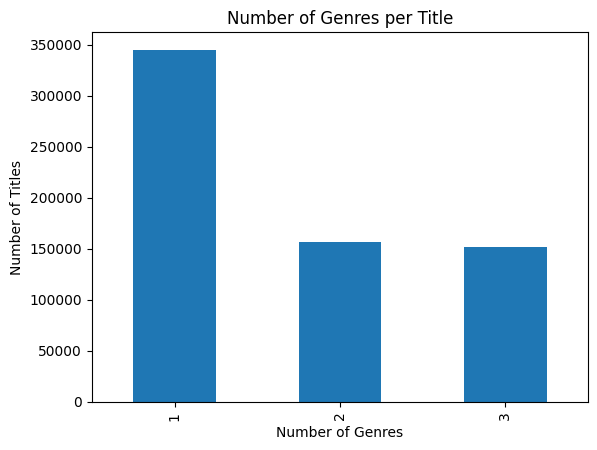

In [88]:
# Most titles have 1 genre, but some have 2 or 3
df['num_genres'].value_counts().plot(
    kind='bar',
    title='Number of Genres per Title',
    xlabel='Number of Genres',
    ylabel='Number of Titles',
)

In [89]:
# Investigate some sample titles - what cleaning is required?
df['title'].sample(20)

101850                       Buried Treasure
259178    One Summer Experience: Sexy Virgin
316982                              Hog Farm
298311                            Blindsided
294787                             Saawariya
597391                        Broken Mirrors
144074            The Revolt of Mamie Stover
625583                      The Chicken Song
16317                             China Heat
103904                          The Wise Kid
331346                       When Women Kill
48898                    Last House Standing
512614       Drug Lord: The Legend of Shorty
371130                         Life Is Yours
278254                   Making Your Mind Up
313982                                  Lair
564801                Pitbull. Nowe porzadki
237253                        Thrill Seekers
30213                                Anarchy
273203                      Interstella 5555
Name: title, dtype: object

In [90]:
# Preprocess / the title text

# Remove numberings (i.e. 1st, 2nd, 3rd, etc.) first so the letters aren't
# stranded after removing the numbers (i.e. 1st -> st, 2nd -> nd)
numbering_re = re.compile(r"(\d+(?:st|nd|rd|th))")

# Keep only alpha characters
alpha_re = re.compile(r"[^a-z]+")

# Remove multiple spaces
multi_space_re = re.compile(r"\s+")

# stop_words = set(stopwords.words('english'))
# Use an abbreviated stopword list to preserve as much contextual information as possible
stop_words = ['for', 'the', 'a', 'an', 'in', 'of', 'as', 'at', 'by', 'for', 'on',
    'and', 'to']

# Don't forget to download wordnet if you haven't already!
# nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """
    Converting to lowercase, keeping only alpha characters, and lemmatizing

    Only removing a select number of stopwords since many stopwords may
    contain useful contextual information for classification
    """
    # Convert unicode to ascii version (to preserve words like Pokémon)
    text = unidecode(text)

    # Lowercase, remove numberings (i.e. 1st, 2nd)
    text = text.lower()
    text = numbering_re.sub(" ", text)

    # Remove apostrophes directly as they cause issues with the tokenizer
    text = text.replace("'", "")

    # Keep only alpha characters
    text = alpha_re.sub(" ", text)

    # Turn multiple spaces into a single space
    text = multi_space_re.sub(" ", text)

    # Tokenize and lemmatize
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    # Try without removing stop words first since they may be important for classification
    # tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

In [91]:
df['title_cleaned'] = df['title'].progress_apply(clean_text)

100%|██████████| 653566/653566 [08:02<00:00, 1354.89it/s] 


In [92]:
df.sample(20)[['title', 'title_cleaned', 'genres']]

,title,title_cleaned,genres
423496,Joka in the Hood,"[joka, hood]","Comedy,Fantasy,Thriller"
32430,Children of the Streets,"[child, street]","Crime,Drama"
560253,Operation Finale,"[operation, finale]","Biography,Drama,History"
492524,Richard Briers: A Tribute,"[richard, brier, tribute]",Documentary
353129,Amityville in the Hood,"[amityville, hood]",Horror
374697,Tebed 2,[tebed],Documentary
516182,The Great Sound of Music,"[great, sound, music]","Music,Talk-Show"
635809,Blood Moon,"[blood, moon]","Fantasy,Mystery,Thriller"
308309,Paths to Peace: Refugee Stonemasons,"[path, peace, refugee, stonemason]",Documentary
149045,The Assassin,[assassin],"Crime,Thriller"


In [93]:
def dummy_function(text):
    """
    Used to run TfIdf with preapplied tokenization and preprocessing
    """
    return text

In [94]:
# Vectorize the text
vectorizer = TfidfVectorizer(
    tokenizer=dummy_function,
    preprocessor=dummy_function,
    analyzer='word',
    token_pattern=None,
    min_df=3,
)

X = vectorizer.fit_transform(df['title_cleaned'])

In [95]:
# Check our cleaning and tokenization by inspecting most frequent tfidf scores
# Many of the top terms would have been removed had we used a more traditional
# stopword list
tfidf_df = pd.DataFrame(
    {
        'tfidf_score' : np.array(X.sum(axis=0)).T[:,0],
    },
    index=vectorizer.get_feature_names_out().T,
)

tfidf_df.sort_values(by='tfidf_score', ascending=False).head(25)

,tfidf_score
love,5745.040338
my,3783.835086
man,3716.125636
life,3573.566670
girl,3312.658226
night,3309.699735
story,3253.049859
day,3082.138818
woman,2855.988216
i,2835.673623


In [96]:
def query_titles(data=df, query_token=None, column='title_cleaned'):
    """
    Check if a token is in the cleaned title. Used to check token context
    """
    return data[data[column].apply(lambda x: str(query_token).lower() in x)]

## Example function usage
# query_token = 'hook'
# query_titles(query_token=query_token).sample(20)[['title', 'title_cleaned', 'genres']]

In [97]:
def evaluate_model(model_name, y_true, y_pred):
    pass

In [98]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [99]:
X_train = vectorizer.transform(train['title_cleaned'])
X_test = vectorizer.transform(test['title_cleaned'])

# Scale the data (only by variance since the input data is a sparse matrix)
scaler = StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = train[genres]
y_test = test[genres]

In [100]:
classifiers = [
    {
        'name' : 'Naive Bayes',
        'clf' : OneVsRestClassifier(MultinomialNB(), verbose=1, n_jobs=-1)
    },
    {
        'name' : 'Logistic Regression',
        'clf' : OneVsRestClassifier(LogisticRegression(max_iter=1000,
                                                       verbose=1,),
                                                       verbose=1,
                                                       n_jobs=-1)
    },
    {
        'name' : 'Linear SVC',
        'clf' : OneVsRestClassifier(LinearSVC(max_iter=1000,
                                              verbose=1,),
                                              verbose=1,
                                              n_jobs=-1)
    },
    {
        'name' : 'K-Nearest Neighbors',
        'clf' : KNeighborsClassifier(n_jobs=-1)
    },
    {
        'name' : 'Random Forest',
        'clf' : RandomForestClassifier(verbose=1, n_jobs=-1)
    },
    {
        'name' : 'Gradient Boosted Trees',
        'clf' : OneVsRestClassifier(GradientBoostingClassifier(verbose=1),
                                    verbose=1,
                                    n_jobs=-1)
    },
]

In [45]:
macro_cols = ['micro avg', 'macro avg', 'weighted avg', 'samples avg']
def eval_model(params):
    clf = params['clf']
    print(f"Training model: {params['name']}")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    macro_results = pd.DataFrame(
        classification_report(
            y_test,
            y_pred,
            target_names=genres,
            output_dict=True
        )
    )[macro_cols].reset_index(names='metric')

    # Add f2-score to macro results
    f2_macro = pd.DataFrame(
        {
            "metric" : ["f2-score"],
            "macro avg" : [fbeta_score(y_test, y_pred, beta=2, average='macro', zero_division=0)],
            "micro avg" : [fbeta_score(y_test, y_pred, beta=2, average='micro', zero_division=0)],
            "weighted avg" : [fbeta_score(y_test, y_pred, beta=2, average='weighted', zero_division=0)],
            "samples avg" : [fbeta_score(y_test, y_pred, beta=2, average='samples', zero_division=0)],
        }
    )
    macro_results = pd.concat([macro_results, f2_macro])
    macro_results['model'] = params['name']
    
    per_class_results = pd.DataFrame(
        classification_report(
            y_test,
            y_pred,
            target_names=genres,
            output_dict=True,
            zero_division=0
        )
    ).drop(columns=macro_cols).T
    
    # Add f2-score to per class results
    f2_scores = fbeta_score(
        y_test,
        y_pred,
        beta=2,
        average=None,
        zero_division=0
    )
    
    per_class_results['f2_score'] = f2_scores

    # save model and results to params dict
    params['clf'] = clf
    params['macro_results'] = macro_results
    params['per_class_results'] = per_class_results
    return macro_results

In [45]:
results_df = []
for classifier in classifiers:
    try:
        eval_model(classifier)
        clf_macro_results = classifier['macro_results']
        results_df.append(clf_macro_results)
    except Exception as e:
        print(f"Error training model: {classifier['name']}")
        print(e)
        continue

if len(results_df) > 1:
    results_df = pd.concat(results_df)
else:
    results_df = results_df[0]

results_df

Training model: Naive Bayes


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    2.2s finished
/Users/eddie/Documents/development/personal/movie_genres/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training model: Logistic Regression


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/Users/eddie/Documents/development/personal/movie_genres/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   40.3s finished
/Users/eddie/Documents/development/personal/movie_genres/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to contr

Training model: Linear SVC


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/Users/eddie/Documents/development/personal/movie_genres/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/eddie/Documents/development/personal/movie_genres/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/eddie/Documents/development/personal/movie_genres/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/eddie/Documents/development/personal/movie_genres/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/eddie/Documents/development/personal

Training model: K-Nearest Neighbors


/Users/eddie/Documents/development/personal/movie_genres/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training model: Random Forest


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 54.5min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.6s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   23.6s finished
/Users/eddie/Documents/development/personal/movie_genres/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training model: Gradient Boosted Trees


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Error training model: Gradient Boosted Trees
WRITEBACKIFCOPY base is read-only


,metric,micro avg,macro avg,weighted avg,samples avg,model
0,precision,0.189205,0.135315,0.301824,0.215552,Naive Bayes
1,recall,0.666408,0.622064,0.666408,0.667378,Naive Bayes
2,f1-score,0.294731,0.202366,0.388976,0.303497,Naive Bayes
3,support,222940.000000,222940.000000,222940.000000,222940.000000,Naive Bayes
0,f2-score,0.442964,0.309664,0.494922,0.429277,Naive Bayes
0,precision,0.591504,0.496356,0.577642,0.387561,Logistic Regression
1,recall,0.283632,0.170990,0.283632,0.308750,Logistic Regression
2,f1-score,0.383414,0.245595,0.359959,0.325987,Logistic Regression
3,support,222940.000000,222940.000000,222940.000000,222940.000000,Logistic Regression
0,f2-score,0.316589,0.193958,0.308050,0.312339,Logistic Regression


In [46]:
# Random forest is pretty clearly the winner here
results_df.query("metric == 'f2-score'")

,metric,micro avg,macro avg,weighted avg,samples avg,model
0,f2-score,0.442964,0.309664,0.494922,0.429277,Naive Bayes
0,f2-score,0.316589,0.193958,0.308050,0.312339,Logistic Regression
0,f2-score,0.319874,0.200083,0.319384,0.305550,Linear SVC
0,f2-score,0.340744,0.175185,0.329691,0.332442,K-Nearest Neighbors
0,f2-score,0.494019,0.371546,0.489937,0.458931,Random Forest


In [103]:
## Test random forest model outside the pipeline (Cheating by fitting
## the tfidf and scalar on the entire dataset)
X = df['title_cleaned'].copy().to_list()
y = df[genres].copy().to_numpy()

vectorizer = TfidfVectorizer(
    tokenizer=dummy_function,
    preprocessor=dummy_function,
    analyzer='word',
    token_pattern=None,
    min_df=3,   
)

scaler = StandardScaler(with_mean=False)

X = vectorizer.fit_transform(X)
X = scaler.fit_transform(X)

# Number of points to sample from the parameter space
n_iter = 6
param_grid = {
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [20, None],
    'rf__min_samples_split': [1, 2],
    'rf__min_samples_leaf': [1, 2],
}

rf_pipeline = Pipeline([
    ('rf', RandomForestClassifier(verbose=1, n_jobs=5))
])

# Use F2 score to weight recall more heavily than precision
# (We don't mind false positives as much as false negatives)

scorer = make_scorer(fbeta_score, beta=2, average='weighted', zero_division=0)

rf_cv = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_grid,
    n_iter=n_iter,

    # Refit on the entire training set with best params
    refit=True,

    scoring=scorer,

    # Use 5-fold cross validation
    cv=5,
    # cv=KFold(n_splits=5, shuffle=True, random_state=42),
    verbose=3,
    error_score='raise',
)

rf_cv.fit(X, y)
print(f"Best model params: {rf_cv.best_params_}")
cv_results_df = pd.DataFrame(rf_cv.cv_results_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


ValueError: buffer source array is read-only

In [102]:
# Find optimal hyperparameters for random forest model and retrain model
# on entire dataset

X = df['title_cleaned'].copy().to_list()
y = df[genres].copy().to_numpy()

rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
                tokenizer=dummy_function,
                preprocessor=dummy_function,
                analyzer='word',
                token_pattern=None,
                min_df=3,   
            )
    ),
    ('scaler', StandardScaler(with_mean=False)),
    ('rf', RandomForestClassifier(verbose=1, n_jobs=5))
])

# Number of points to sample from the parameter space
n_iter = 6
param_grid = {
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [20, None],
    'rf__min_samples_split': [1, 2],
    'rf__min_samples_leaf': [1, 2],
}

# Use F2 score to weight recall more heavily than precision
# (We don't mind false positives as much as false negatives)

scorer = make_scorer(fbeta_score, beta=2, average='weighted', zero_division=0)

rf_cv = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_grid,
    n_iter=n_iter,

    # Refit on the entire training set with best params
    refit=True,

    # scoring=scorer,
    # scoring=scorer,

    # Use 5-fold cross validation
    cv=5,
    # cv=KFold(n_splits=5, shuffle=True, random_state=42),
    verbose=3,
    error_score='raise',
)

rf_cv.fit(X, y)
print(f"Best model params: {rf_cv.best_params_}")
cv_results_df = pd.DataFrame(rf_cv.cv_results_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


ValueError: buffer source array is read-only

In [ ]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                            df: 912.3 MiB
                         train: 733.9 MiB
                          test: 183.4 MiB
                          temp: 139.6 MiB
                       y_train: 115.7 MiB
                        y_test: 28.9 MiB
                             X:  5.0 MiB
                      tfidf_df:  2.3 MiB
                           _12: 10.5 KiB
                           _22:  6.6 KiB


In [ ]:
# Save out pipeline object
with open('rf_pipeline.pkl', 'wb') as f:
    joblib.dump(rf_cv.best_estimator_, f)

In [ ]:
# Full prediction pipeline
text = "The Lord of the Ring: The Fellowship of the Ring"
text = clean_text(text)
pred = rf_cv.predict(text)
pred = pd.DataFrame(pred, columns=genres)

# Take only nonzero columns
pred = pred.T[pred.T[0] == 1].index.tolist()
pred

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


[]

In [ ]:
### Example of multi-label classification

# from sklearn.datasets import make_multilabel_classification
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
# from sklearn.model_selection import train_test_split

# # Build a synthetic dataset
# X, y = make_multilabel_classification(
#     n_samples=100, n_labels=3, n_features=5, n_classes=4
# )

# y[0:4]